C:\Users\erikm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Model 1 - Accuracy: 0.7311
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Model 2 - Accuracy: 0.7351
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Model 3 - Accuracy: 0.7346


C:\Users\erikm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Final Model Performance:
Accuracy: 0.7336
Precision: 0.7202
Recall: 0.5892
F1 Score: 0.6481


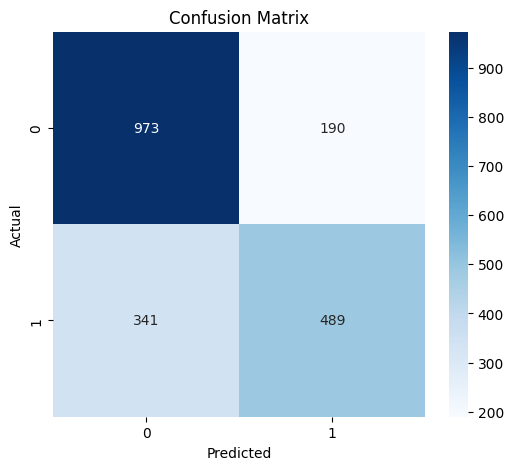

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load dataset (update the path)
df = pd.read_csv("placementdata.csv")

# Handle missing values
df.dropna(inplace=True)

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Identify target column
target_column = df.columns[-1]  # Assuming the last column is the target
y = df[target_column]
X = df.drop(columns=[target_column])

# Remove multicollinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
X = X.loc[:, vif_data[vif_data["VIF"] < 10]["feature"]]

# Mutual Information Analysis
mi_scores = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores}).sort_values(by='MI Score', ascending=False)
highest_mi_feature = mi_df.iloc[0, 0]
X = X.drop(columns=[highest_mi_feature])

# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define function to build and train models
def build_train_model(hidden_layers, neurons, dropout_rate=0, use_regularization=False):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping], verbose=0)
    return model, history

# Train three models
models = []
histories = []
layer_configs = [(1, 32), (2, 64), (3, 128)]

for layers, neurons in layer_configs:
    model, history = build_train_model(layers, neurons)
    models.append(model)
    histories.append(history)

# Evaluate models
best_model_idx = -1
best_accuracy = 0
for i, model in enumerate(models):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    print(f"Model {i+1} - Accuracy: {acc:.4f}")
    if acc > best_accuracy:
        best_accuracy = acc
        best_model_idx = i

# Retrain best model with improvements
best_layers, best_neurons = layer_configs[best_model_idx]
best_model, best_history = build_train_model(best_layers, best_neurons, dropout_rate=0.3, use_regularization=True)

# Final evaluation
y_pred = (best_model.predict(X_test) > 0.5).astype(int)
print("Final Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
